In [1]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.1 MB/s eta 0:00:00


In [2]:
import zipfile
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,ParameterGrid
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV
import os
from torch.utils.data import TensorDataset
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import json
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import copy
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
from nlpaug.util import Action
from sklearn.utils import shuffle
from itertools import chain

In [3]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
    device = torch.device("cuda")  # Select GPU device
else:
    print("CUDA is not available. Training on CPU.")
    device = torch.device("cpu")

CUDA is available. Training on GPU.


In [4]:
import warnings
warnings.filterwarnings("ignore")

# **Data labels proportion**

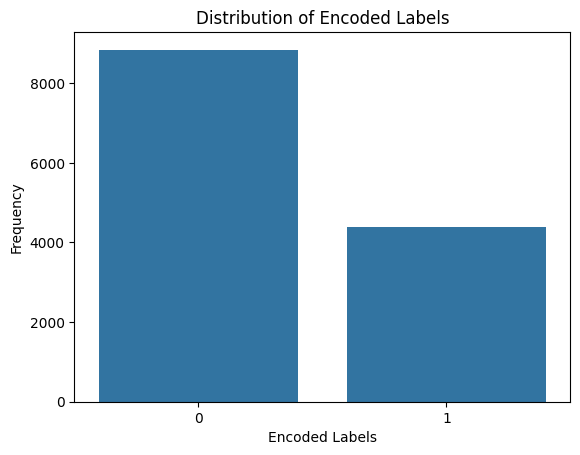

In [5]:
columnns = ["id", "tweet", "subtask_a", "subtask_b", "subtask_c"]

#with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f: - Used it if you run locally

with open('/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
    df = pd.read_csv(f, sep='\t', header=None, names=columnns)

df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)

sns.countplot(x='subtask_a', data=df)
plt.title('Distribution of Encoded Labels')
plt.xlabel('Encoded Labels')
plt.ylabel('Frequency')
plt.show()

# **Below are the functions to pre-process the data (fetching, cleaning, tokenization)**

In [6]:
def process_data(max_length=100):
    columnns = ["id", "tweet", "subtask_a", "subtask_b", "subtask_c"]

    #with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f: - Used it if you run locally

    with open('/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=columnns)

    df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
    df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
    tweets = df['tweet'].astype(str)
    tweets_cleaned = tweets.apply(clean_text)

    encoder = LabelEncoder()
    labels = encoder.fit_transform(df['subtask_a'])

    return tweets_cleaned, labels

def process_test_data(max_length=100):
    columnns = ["id", "tweet"]

    #with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f:  - Used it if you run locally
    with open('/kaggle/input/oidset/OLID_TEST_A_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
        df = pd.read_csv(f, sep='\t', header=None, names=columnns)

    df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
    df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
    tweets = df['tweet'].astype(str)
    tweets_cleaned = tweets.apply(clean_text)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_cleaned)
    vocab_size = len(tokenizer.word_index)
    sequence = tokenizer.texts_to_sequences(tweets_cleaned)

    max_length_default = max_length
    max_length_new = get_sequence_max_length(sequence)

    if max_length_new> 0 and max_length_new<max_length_default:
        max_length = max_length_new

    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')

    features = np.array(padded_sequence)

    encoder = LabelEncoder()
    df['subtask_a'] = df.dropna(subset=['subtask_a'])
    labels = encoder.fit_transform(df['subtask_a'])

    sns.countplot(x='subtask_a', data=df)
    plt.title('Distribution of Encoded Labels for subtask_a')
    plt.xlabel('Encoded Labels')
    plt.ylabel('Frequency')
    plt.show()

    return features, labels, vocab_size, max_length

def get_sequence_max_length(sequences):

    max_length = 0

    # Iterate through each sequence
    for sequence in sequences:
        # Calculate the length of the sequence
        length = len(sequence)

        # Update max_length if the current sequence is longer
        if length > max_length:
            max_length = length

    return max_length

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+', '', text)
    text = re.sub(r'\#\w+', '', text)
    text = re.sub(r"[^a-zA-Z']", ' ', text)  # Keep letters and apostrophes
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


# **Below is LSTM model and its training and test functions**

In [7]:
# LSTM model
class SimpleLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout=0.2):
        super(SimpleLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        lstm_out = self.bn(lstm_out.permute(0, 2, 1)).permute(0, 2, 1)
        output = self.fc(ht[-1])
        return output

# Function to train the model
def train_lstm(model, train_loader,val_loader, optimizer, criterion,epochs,model_name, patience=60):
    model.to(device)
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs).squeeze(1)
                val_loss = criterion(outputs,labels)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
                break


    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_name)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



# Function to test the model
def test_lstm(model, test_loader,model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            predictions = model(inputs).squeeze(1)
            predicted_classes = (predictions >= 0.5).float()
            all_predictions.extend(predicted_classes.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **Below is BiLSTM model and its training and test functions**

In [8]:
# BiLSTM model
class Attention(nn.Module):
    """ Attention mechanism to weight the importance of different steps in the sequence. """
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(feature_dim, 1)

    def forward(self, x):
        # x.shape: (batch_size, seq_length, features)
        scores = self.attention(x).squeeze(2)  # Reduce features dimension to 1
        alpha = F.softmax(scores, dim=1).unsqueeze(2)  # Get the weights
        weighted = torch.sum(x * alpha, dim=1)  # Sum weighted features
        return weighted

class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Bidirectional LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)

        # Attention Layer
        self.attention = Attention(hidden_size * 2)  # Use the concatenated output for attention

        # Batch Normalization Layer
        self.bn = nn.BatchNorm1d(hidden_size * 2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # First dense layer
        self.fc2 = nn.Linear(hidden_size, output_size)      # Output layer

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)

        # LSTM layer
        lstm_out, _ = self.lstm(x)  # lstm_out.shape: (batch_size, seq_length, hidden_dim * 2)

        # Attention layer
        attended = self.attention(lstm_out)  # attended.shape: (batch_size, hidden_dim * 2)

        # Batch Normalization
        normalized = self.bn(attended)

        # Dropout and fully connected layers
        out = self.dropout(normalized)
        out = F.relu(self.fc1(out))  # Activation function
        out = self.fc2(out)  # Final output layer
        return out

# Function to train the model
def train_bilstm(model, train_loader,val_loader, optimizer, criterion,epochs,model_name, patience=60):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

        model.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                #labls = torch.nn.functional.one_hot(labels, num_classes=2)
                labels = labels.to(device).float()
                outputs = model(inputs)
                val_loss = criterion(outputs.squeeze(),labels)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
                break

    model.load_state_dict(best_model)
    torch.save(model.state_dict(), model_name)

    # Plot training and validation losses
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()



# Function to test the model
def test_bilstm(model, test_loader,model_name):
    model.load_state_dict(torch.load(model_name))
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            predictions = model(inputs).squeeze(1)
            predicted_classes = (predictions >= 0.5).float()
            all_predictions.extend(predicted_classes.tolist())
            all_labels.extend(labels.tolist())

    # Calculate metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# **Here we prepare fucntions fo grid search**

In [9]:
def get_padded_sequences(tokenizer,texts, max_length):
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    return np.array(padded_sequences)

def augment_text_data(text, num_augments=1):
    # Create augmenters
    aug_syn = naw.SynonymAug(aug_src='wordnet')
    aug_del = naw.RandomWordAug(action="delete")
    aug_swap = naw.RandomWordAug(action="swap")

    augmented_texts = []

    for _ in range(num_augments):
        # Apply augmentations
        augmented_texts.append(aug_syn.augment(text))


    return augmented_texts

def create_loaders(batch_size):
    X, y = process_data()

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

    # Augmenation for train dataset
    unique, counts = np.unique(y_train, return_counts=True)
    class_distribution = dict(zip(unique, counts))
    # Calculate the maximum count to identify how much to augment
    max_count = max(counts)
    augment_factor = {label: max_count // count for label, count in class_distribution.items()}

    # New lists to hold the augmented data
    augmented_X_train = list(X_train)  # Start with original data
    augmented_y_train = list(y_train)

    # Augment data with different intensities based on class frequency
    for text, label in zip(X_train, y_train):
        if label == 1:
          num_augments = augment_factor[label]
          augmented_texts = augment_text_data(text, num_augments)
          augmented_texts = ' '.join(chain.from_iterable(augmented_texts))
          augmented_X_train.extend([augmented_texts])
          augmented_y_train.extend([label])



    # Shuffle the augmented data
    augmented_X_train, augmented_y_train = shuffle(augmented_X_train, augmented_y_train, random_state=42)

    # Convert lists to arrays for consistency if using frameworks that prefer arrays
    X_train = pd.Series(augmented_X_train)
    y_train = pd.Series(augmented_y_train)

    new_distribution = np.unique(y_train, return_counts=True)


    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)
    vocab_size = len(tokenizer.word_index)

    max_length = max(max(len(x.split()) for x in X_train),  # Find max length from augmented data
                 max(len(x.split()) for x in X_val),
                 max(len(x.split()) for x in X_test))


    X_train_padded = get_padded_sequences(tokenizer,X_train, max_length)
    X_val_padded = get_padded_sequences(tokenizer,X_valid, max_length)
    X_test_padded = get_padded_sequences(tokenizer,X_test, max_length)

    X_train_features = np.array(X_train_padded)
    X_val_features = np.array(X_val_padded)
    X_test_features = np.array(X_test_padded)




    # Convert X_train and y_train to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_features)
    y_train_tensor = torch.tensor(y_train)
    X_valid_tensor = torch.tensor(X_val_features)
    y_valid_tensor = torch.tensor(y_valid)
    X_test_tensor = torch.tensor(X_test_features)
    y_test_tensor = torch.tensor(y_test)

    # Create a TensorDataset
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=4)

    return train_loader,valid_loader,test_loader,vocab_size,class_distribution,new_distribution

class EarlyStopping:
    def __init__(self, patience=30, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                           Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1

            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''

        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


def train_evaluate(model, train_loader, val_loader, epochs, learning_rate, criterion_name,optimizer_name,momentum=None, alpha=0.99, patience=20,weight_decay=0.001):

    optimizer = get_optimizer(model, optimizer_name, learning_rate, momentum)
    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = weight_decay

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    criterion = get_criterion(criterion_name)
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(1), labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).float()
                outputs = model(inputs)
                val_loss += criterion(outputs.squeeze(1), labels).item()

        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            break

    model.load_state_dict(torch.load('best_model.pt'))  # Load the last best model
    return val_loss,model

def get_optimizer(model, optimizer_name, learning_rate, momentum=None, alpha=0.99):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    elif optimizer_name == 'rmsprop':
        return torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha)
    else:
        raise ValueError("Unsupported optimizer: {}".format(optimizer_name))

def get_criterion(name):
    if name == 'bce_logits':
        return torch.nn.BCEWithLogitsLoss()
    elif name == 'cross_entropy':
        return torch.nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported loss function: {}".format(name))


In [10]:
train_loader,valid_loader,test_loader,vocab_size,class_distribution,new_distribution = create_loaders(32)
print("Original class distribution:",class_distribution)
print("New class distribution:", dict(zip(new_distribution[0], new_distribution[1])))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Original class distribution: {0: 6163, 1: 3105}
New class distribution: {0: 6163, 1: 6210}


# **Here we conduct a grid search for the (standard) LSTM model, followed by training and model enhancement**

In [ ]:
param_grid = {
    'embedding_dim': [300,400],
    'hidden_size': [128, 256],
    'num_layers': [2,4],
    'dropout': [0.3,0.5],
    'optimizer': ['adam'],
    'criterion': ['bce_logits'],
    'epochs': [200],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [32,64]
}

# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)


# Storage for results
results = []
best_val_loss = float('inf')

i =1
for params in param_grid:
    # __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, output_size, dropout=0.2):
    model = SimpleLSTMModel(vocab_size=vocab_size+ 1, embedding_dim=params['embedding_dim'],hidden_size=params['hidden_size'], dropout=params['dropout'], num_layers=params['num_layers'], output_size=1)
    if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model = nn.DataParallel(model)

    train_loader,valid_loader,test_loader,_,_,_ = create_loaders(params['batch_size'])

    momentum=params.get('momentum', 0)
    alpha=params.get('alpha', 0.99)
    val_loss,best_model = train_evaluate(model, train_loader, valid_loader, epochs=params['epochs'], learning_rate=params['learning_rate'],optimizer_name=params['optimizer'],criterion_name=params['criterion'],momentum=momentum,alpha=alpha)

    with open('lstm_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"New Best Model (number {i}) Parameters: {params}")
        # Save the model state
        torch.save(best_model.state_dict(), 'best_lstm_model.pth')

    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)

New best validation loss: 0.6940507907716055
New Best Model (number 1) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 300, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 0.6939801110161675
New Best Model (number 4) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 300, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.001, 'num_layers': 4, 'optimizer': 'adam'}
New best validation loss: 0.6937034546382843
New Best Model (number 17) Parameters: {'batch_size': 32, 'criterion': 'bce_logits', 'dropout': 0.5, 'embedding_dim': 300, 'epochs': 200, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 0.6936676595360041
New Best Model (number 46) Parameters: {'batch_size': 64, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 400, 'epochs': 200, 'hidden_size': 256, 'l

# **Traing and testing the 1st best LSTM model**

In [28]:
embedding_dim = 400
hidden_size = 256
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

model_simple_lstm_1 = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_1.to(device)
model_name = 'model_simple_lstm_1.pth'

optimizer = get_optimizer(model_simple_lstm_1, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay

criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.6932, Validation Loss: 0.6915
Epoch 20/300, Training Loss: 0.6934, Validation Loss: 0.6932
Epoch 30/300, Training Loss: 0.6929, Validation Loss: 0.6976
Epoch 40/300, Training Loss: 0.6926, Validation Loss: 0.6932
Epoch 50/300, Training Loss: 0.6931, Validation Loss: 0.6951
Epoch 60/300, Training Loss: 0.6930, Validation Loss: 0.6932
Epoch 70/300, Training Loss: 0.6922, Validation Loss: 0.6960
Epoch 80/300, Training Loss: 0.6923, Validation Loss: 0.6932
Epoch 90/300, Training Loss: 0.6940, Validation Loss: 0.6932
Epoch 100/300, Training Loss: 0.6922, Validation Loss: 0.6932
Validation loss has not improved for 90 epochs. Early stopping...


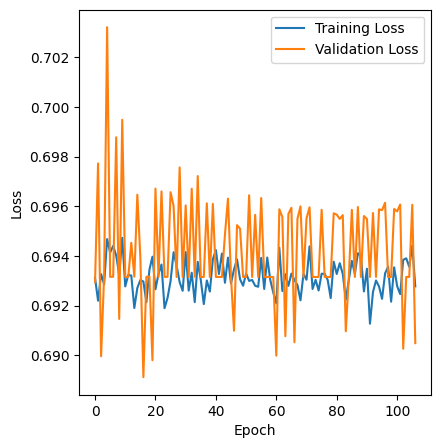

In [14]:
train_lstm(model_simple_lstm_1, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


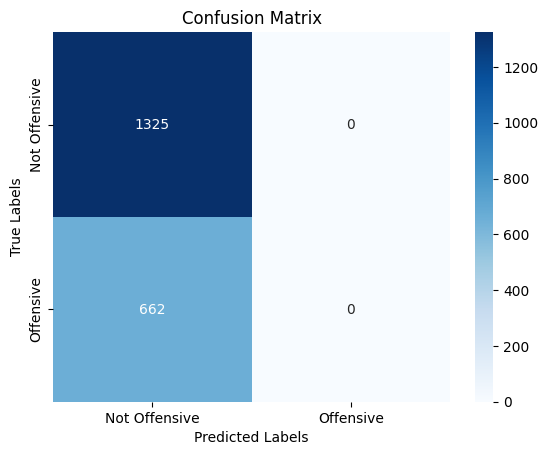

In [29]:
test_lstm(model_simple_lstm_1, test_loader,model_name)

# **Now we try to enhance result by overcoming data imbalance**

In [30]:
# Adding class weights to overcome data imbalance
embedding_dim = 400
hidden_size = 256
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

# Calculate class weights
X, y = process_data()
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_lstm_1_cw = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_1_cw.to(device)
model_name = 'model_simple_lstm_1_cw.pth'

optimizer = get_optimizer(model_simple_lstm_1_cw, optimizer_name, learning_rate, momentum)
# Update the weights in the optimizer
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)
train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.6938, Validation Loss: 0.6910
Epoch 20/300, Training Loss: 0.6939, Validation Loss: 0.6932
Epoch 30/300, Training Loss: 0.6962, Validation Loss: 0.6932
Epoch 40/300, Training Loss: 0.6945, Validation Loss: 0.6988
Epoch 50/300, Training Loss: 0.6929, Validation Loss: 0.6994
Epoch 60/300, Training Loss: 0.6935, Validation Loss: 0.6999
Epoch 70/300, Training Loss: 0.6904, Validation Loss: 0.6866
Epoch 80/300, Training Loss: 0.6923, Validation Loss: 0.6870
Epoch 90/300, Training Loss: 0.6924, Validation Loss: 0.6876
Epoch 100/300, Training Loss: 0.6945, Validation Loss: 0.6877
Epoch 110/300, Training Loss: 0.6915, Validation Loss: 0.6883
Epoch 120/300, Training Loss: 0.6951, Validation Loss: 0.6932
Epoch 130/300, Training Loss: 0.6939, Validation Loss: 0.6932
Validation loss has not improved for 90 epochs. Early stopping...


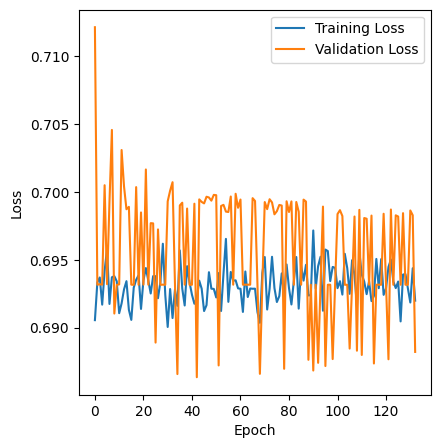

In [17]:
train_lstm(model_simple_lstm_1_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


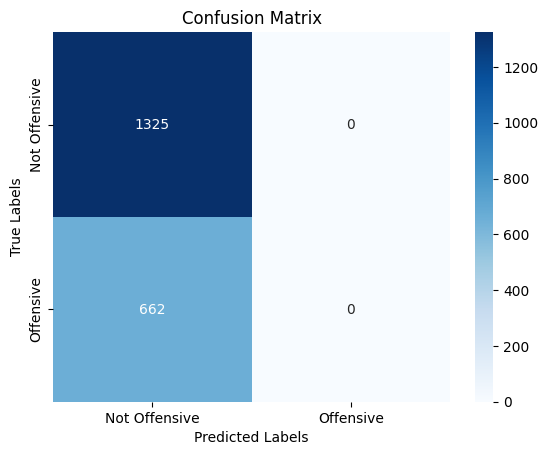

In [31]:
test_lstm(model_simple_lstm_1_cw, test_loader,model_name)

In [32]:
# Adding more layers
embedding_dim = 500
hidden_size = 512
num_layers = 8
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
momentum = 0.9
epochs = 300
weight_decay=0.001
batch_size = 64

# Calculate class weights
X, y = process_data()
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_lstm_2_cw = SimpleLSTMModel(vocab_size +1, embedding_dim, hidden_size, num_layers, output_size, dropout)
model_simple_lstm_2_cw.to(device)
model_name = 'model_simple_lstm_2_cw.pth'

optimizer = get_optimizer(model_simple_lstm_2_cw, optimizer_name, learning_rate, momentum)
# Update the weights in the optimizer
for param_group in optimizer.param_groups:
    param_group['weight_decay'] = weight_decay
    param_group['weight'] = class_weights_tensor


criterion = get_criterion(criterion_name)
train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.6969, Validation Loss: 0.6932
Epoch 20/300, Training Loss: 0.6927, Validation Loss: 0.6932
Epoch 30/300, Training Loss: 0.6918, Validation Loss: 0.6973
Epoch 40/300, Training Loss: 0.6924, Validation Loss: 0.6989
Epoch 50/300, Training Loss: 0.6934, Validation Loss: 0.6990
Epoch 60/300, Training Loss: 0.6912, Validation Loss: 0.6932
Epoch 70/300, Training Loss: 0.6945, Validation Loss: 0.6932
Epoch 80/300, Training Loss: 0.6919, Validation Loss: 0.6932
Epoch 90/300, Training Loss: 0.6924, Validation Loss: 0.6986
Validation loss has not improved for 90 epochs. Early stopping...


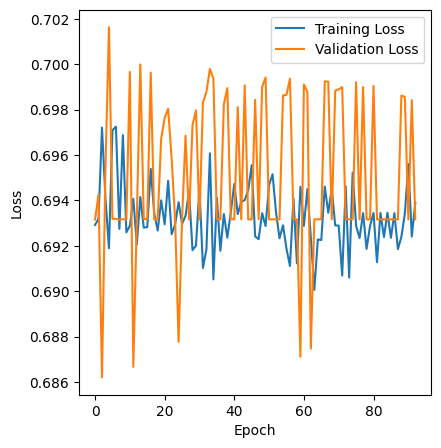

In [20]:
train_lstm(model_simple_lstm_2_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


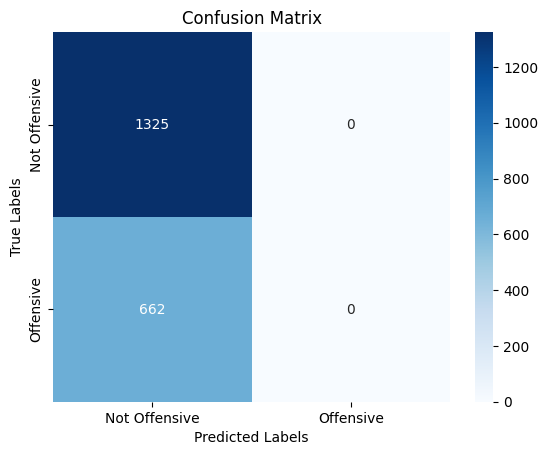

In [33]:
test_lstm(model_simple_lstm_2_cw, test_loader,model_name)

# **Here we conduct a grid search for the BiLSTM model, followed by training and model enhancement**

In [14]:
param_grid = {
    'embedding_dim': [300,400],
    'hidden_size': [128],
    'num_layers': [2, 4],
    'dropout': [0.3,0.5],
    'optimizer': ['adam'],
    'criterion': ['bce_logits'],
    'epochs': [300],
    'learning_rate': [0.0001, 0.001],
    'batch_size': [64]
}

# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
best_val_loss = float('inf')
i = 1
for params in param_grid:
    #BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
    model = BiLSTMModel(vocab_size=vocab_size+ 1, embedding_dim=params['embedding_dim'],hidden_size=params['hidden_size'], dropout=params['dropout'], num_layers=params['num_layers'], output_size=1)
    if torch.cuda.device_count() > 1:
        # This wrapper handles the distribution of data to and gathering from the GPUs
        model = nn.DataParallel(model)
    train_loader,valid_loader,test_loader,_,_,_  = create_loaders(params['batch_size'])  # Assume a function that creates data loaders
    momentum=params.get('momentum', 0)
    alpha=params.get('alpha', 0.99)
    val_loss,best_model = train_evaluate(model, train_loader, valid_loader, epochs=params['epochs'], learning_rate=params['learning_rate'],optimizer_name=params['optimizer'],criterion_name=params['criterion'],momentum=momentum,alpha=alpha)
    with open('bilstm_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"New Best Model (number {i}) Parameters: {params}")
        # Save the model state
        torch.save(best_model.state_dict(), 'best_bilstm_model.pth')
    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)


New best validation loss: 1.2998191313818097
New Best Model (number 1) Parameters: {'batch_size': 64, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 300, 'epochs': 300, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
New best validation loss: 1.2722950133029372
New Best Model (number 5) Parameters: {'batch_size': 64, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 400, 'epochs': 300, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}
Final Best Validation Loss: 1.2722950133029372
Best Parameters: {'batch_size': 64, 'criterion': 'bce_logits', 'dropout': 0.3, 'embedding_dim': 400, 'epochs': 300, 'hidden_size': 128, 'learning_rate': 0.0001, 'num_layers': 2, 'optimizer': 'adam'}


# **Traing and testing the 1st best BiLSTM model**

In [34]:
embedding_dim = 400
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 64
epochs = 300

model_simple_bilstm_1 = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_1.to(device)
model_name = 'model_simple_bilstm_1.pth'
optimizer = get_optimizer(model_simple_bilstm_1, optimizer_name, learning_rate, momentum)
criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.4671, Validation Loss: 0.7860
Epoch 20/300, Training Loss: 0.0022, Validation Loss: 3.2199
Epoch 30/300, Training Loss: 0.0018, Validation Loss: 3.4609
Epoch 40/300, Training Loss: 0.0277, Validation Loss: 3.0101
Epoch 50/300, Training Loss: 0.0054, Validation Loss: 0.0611
Epoch 60/300, Training Loss: 0.0001, Validation Loss: 4.9511
Epoch 70/300, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 80/300, Training Loss: 0.0007, Validation Loss: 0.0302
Epoch 90/300, Training Loss: 0.0001, Validation Loss: 1.5153
Epoch 100/300, Training Loss: 0.0000, Validation Loss: 0.0006
Epoch 110/300, Training Loss: 0.0001, Validation Loss: 0.1632
Epoch 120/300, Training Loss: 0.0013, Validation Loss: 4.1934
Epoch 130/300, Training Loss: 0.0315, Validation Loss: 6.9977
Validation loss has not improved for 90 epochs. Early stopping...


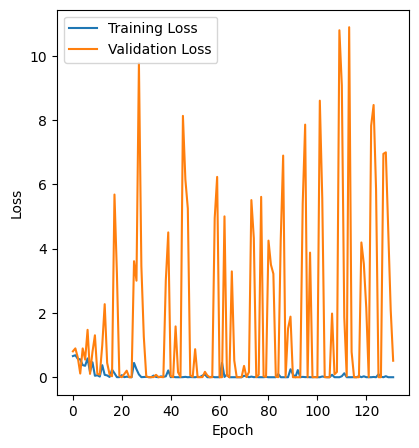

In [22]:
train_bilstm(model_simple_bilstm_1, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.5590
Recall: 0.5438
F1 Score: 0.5513
Accuracy: 0.7051


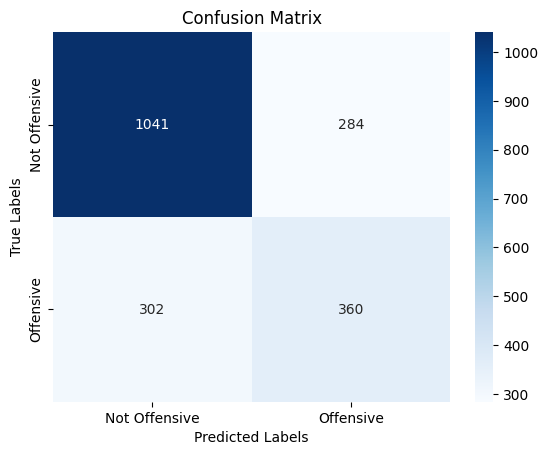

In [35]:
test_bilstm(model_simple_bilstm_1, test_loader,model_name)

# **Now we try to enhance result by overcoming data imbalance**

In [36]:
# Adding class weights to overcome data imbalance
embedding_dim = 400
hidden_size = 128
num_layers = 2
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 64
epochs = 300

# Calculate class weights
X, y = process_data()
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

model_simple_bilstm_1_cw = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_1_cw.to(device)
model_name = 'model_simple_bilstm_1_cw.pth'

optimizer = get_optimizer(model_simple_bilstm_1_cw, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight'] = class_weights_tensor

criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.1082, Validation Loss: 0.0021
Epoch 20/300, Training Loss: 0.0368, Validation Loss: 1.6996
Epoch 30/300, Training Loss: 0.0008, Validation Loss: 0.7531
Epoch 40/300, Training Loss: 0.0010, Validation Loss: 0.0000
Epoch 50/300, Training Loss: 0.0071, Validation Loss: 0.0083
Epoch 60/300, Training Loss: 0.1643, Validation Loss: 5.0223
Epoch 70/300, Training Loss: 0.0001, Validation Loss: 0.9942
Epoch 80/300, Training Loss: 0.0002, Validation Loss: 6.5970
Epoch 90/300, Training Loss: 0.1119, Validation Loss: 0.0000
Epoch 100/300, Training Loss: 0.0005, Validation Loss: 4.9440
Epoch 110/300, Training Loss: 0.0097, Validation Loss: 6.3074
Epoch 120/300, Training Loss: 0.0040, Validation Loss: 5.9341
Epoch 130/300, Training Loss: 0.0001, Validation Loss: 0.0000
Epoch 140/300, Training Loss: 0.0085, Validation Loss: 5.4349
Validation loss has not improved for 90 epochs. Early stopping...


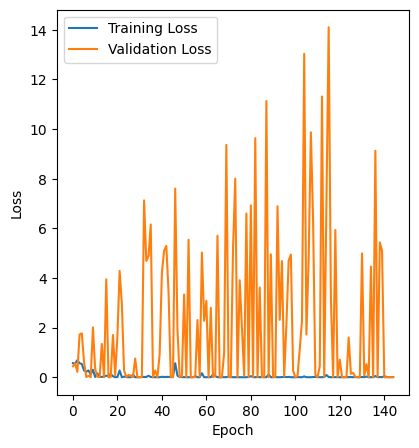

In [24]:
train_bilstm(model_simple_bilstm_1_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.5585
Recall: 0.5332
F1 Score: 0.5456
Accuracy: 0.7041


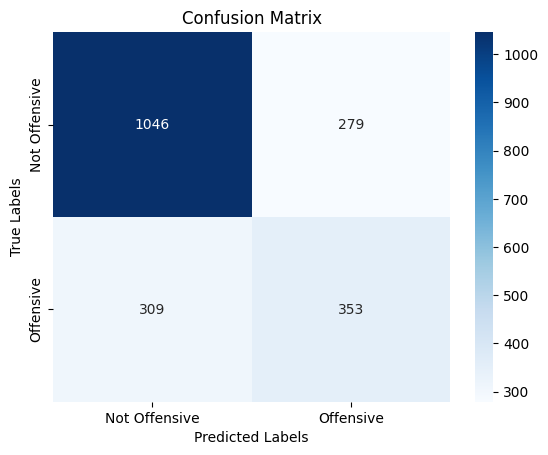

In [37]:
test_bilstm(model_simple_bilstm_1_cw, test_loader,model_name)

In [38]:
# Adding more layers
embedding_dim = 500
hidden_size = 256
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 0.0001
criterion_name = 'bce_logits'
optimizer_name= 'adam'
batch_size = 64
epochs = 300

X, y = process_data()
class_weights = compute_class_weight(class_weight='balanced', classes = np.unique(y),y= y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


model_simple_bilstm_2_cw = BiLSTMModel(vocab_size +1, embedding_dim, hidden_size, output_size,num_layers,dropout)
model_simple_bilstm_2_cw.to(device)
model_name = 'model_simple_bilstm_2_cw.pth'

optimizer = get_optimizer(model_simple_bilstm_2_cw, optimizer_name, learning_rate, momentum)
for param_group in optimizer.param_groups:
    param_group['weight'] = class_weights_tensor
criterion = get_criterion(criterion_name)

train_loader,valid_loader,test_loader,_,_,_ = create_loaders(batch_size)

Epoch 10/300, Training Loss: 0.0327, Validation Loss: 0.0088
Epoch 20/300, Training Loss: 0.0011, Validation Loss: 0.0030
Epoch 30/300, Training Loss: 0.0834, Validation Loss: 7.0978
Epoch 40/300, Training Loss: 0.0007, Validation Loss: 3.4193
Epoch 50/300, Training Loss: 0.0125, Validation Loss: 0.2618
Epoch 60/300, Training Loss: 0.0446, Validation Loss: 0.0028
Epoch 70/300, Training Loss: 0.0003, Validation Loss: 0.0916
Epoch 80/300, Training Loss: 0.0069, Validation Loss: 0.0000
Epoch 90/300, Training Loss: 0.0000, Validation Loss: 0.0000
Epoch 100/300, Training Loss: 0.0002, Validation Loss: 0.0041
Epoch 110/300, Training Loss: 0.0081, Validation Loss: 4.1894
Epoch 120/300, Training Loss: 0.1042, Validation Loss: 0.0016
Epoch 130/300, Training Loss: 0.0002, Validation Loss: 0.3839
Epoch 140/300, Training Loss: 0.0001, Validation Loss: 6.6029
Epoch 150/300, Training Loss: 0.0943, Validation Loss: 0.0116
Epoch 160/300, Training Loss: 0.0001, Validation Loss: 8.0695
Epoch 170/300, Tr

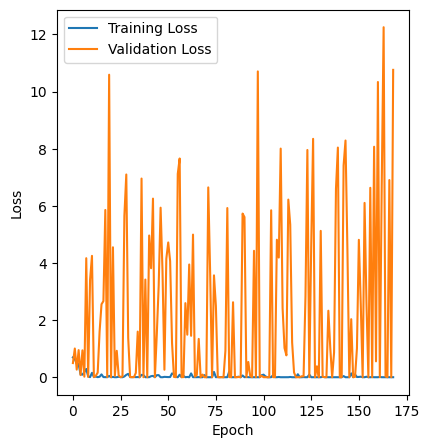

In [26]:
train_bilstm(model_simple_bilstm_2_cw, train_loader,valid_loader, optimizer, criterion,epochs,model_name,patience=90)

Precision: 0.5945
Recall: 0.5272
F1 Score: 0.5588
Accuracy: 0.7227


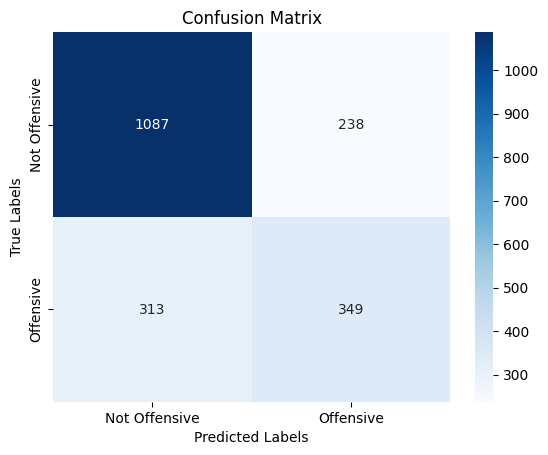

In [39]:
test_bilstm(model_simple_bilstm_2_cw, test_loader,model_name)

# Here we develop and train BERT model

In [ ]:
#Train and test function
def train_bert(model, train_loader,val_loader, optimizer, criterion,num_epochs,model_name, patience=30):
  best_val_loss = float('inf')
  best_model_state = None
  early_stopping_counter = 0

  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
      model.train()
      epoch_train_losses = []
      for batch in train_loader:
          input_ids = batch[0].to(device)
          attention_mask = batch[1].to(device)
          labels = batch[2].to(device)
          optimizer.zero_grad()
          outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
          loss = criterion(outputs.logits, labels)
          loss.backward()
          optimizer.step()
          epoch_train_losses.append(loss.item())

      # Calculate average training loss for the epoch
      train_loss = np.mean(epoch_train_losses)
      train_losses.append(train_loss)

      # Evaluate the model on the validation set
      model.eval()
      epoch_val_losses = []
      val_preds = []
      val_true = []
      for batch in val_loader:
          input_ids = batch[0].to(device)
          attention_mask = batch[1].to(device)
          labels = batch[2].to(device)

          with torch.no_grad():
              outputs = model(input_ids, attention_mask=attention_mask)
              logits = outputs.logits
              preds = torch.argmax(logits, dim=1)
              val_loss = criterion(logits, labels)
              epoch_val_losses.append(val_loss.item())

          val_preds.extend(preds.cpu().numpy())
          val_true.extend(labels.cpu().numpy())

      # Calculate average validation loss for the epoch
      val_loss = np.mean(epoch_val_losses)
      val_losses.append(val_loss)

      val_accuracy = accuracy_score(val_true, val_preds)

      # Print training and validation losses
      if (epoch +1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

      # Save the best model based on validation loss
      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_model_state = model.state_dict()
          early_stopping_counter = 0
      else:
          early_stopping_counter += 1
          if early_stopping_counter >= patience:
              print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
              break

  # Save the best model
  torch.save(best_model_state, model_name)

  # Plot training and validation losses
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

def test_bert(model, test_loader,model_name):
  model.load_state_dict(torch.load(model_name))
  model.eval()
  all_predictions = []
  all_labels = []
  for batch in test_loader:
      input_ids = batch[0].to(device)
      attention_mask = batch[1].to(device)
      labels = batch[2].to(device)

      with torch.no_grad():
          outputs = model(input_ids, attention_mask=attention_mask)
          logits = outputs.logits
          preds = torch.argmax(logits, dim=1)

      all_predictions.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # Calculate metrics
  precision = precision_score(all_labels, all_predictions)
  recall = recall_score(all_labels, all_predictions)
  f1 = f1_score(all_labels, all_predictions)
  accuracy = accuracy_score(all_labels, all_predictions)

  # Calculate the confusion matrix
  conf_matrix = confusion_matrix(all_labels, all_predictions)

  print(f'Precision: {precision:.4f}')
  print(f'Recall: {recall:.4f}')
  print(f'F1 Score: {f1:.4f}')
  print(f'Accuracy: {accuracy:.4f}')
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Offensive', 'Offensive'], yticklabels=['Not Offensive', 'Offensive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.show()

In [ ]:
def train_evaluate_bert(model, train_loader, val_loader, epochs, criterion,optimizer_name,patience=60):

    scheduler = ReduceLROnPlateau(optimizer, 'min')
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    model.to(device)
    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch[0].to(device)
                attention_mask = batch[1].to(device)
                labels = batch[2].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                val_loss += criterion(logits, labels)
                #epoch_val_losses.append(val_loss.item())

        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            break

    model.load_state_dict(torch.load('best_bert_model.pt'))  # Load the last best model
    return val_loss,model


In [ ]:
def prepeare_data_for_bert(batch_size=32,num_workers=2):
  columnns = ["id", "tweet", "subtask_a", "subtask_b", "subtask_c"]

  #with zipfile.ZipFile('OlidPreprcessed.zip') as zip_f: - Used it if you run locally
  with open('/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', 'r') as f:
      df = pd.read_csv(f, sep='\t', header=None, names=columnns)

  df.drop(["id", "subtask_b", "subtask_c"], axis=1, inplace=True)
  df['subtask_a'] = df['subtask_a'].apply(lambda x: 1 if x == 'OFF' else 0)
  tweets = df['tweet'].astype(str)
  tweets_cleaned = tweets.apply(clean_text).tolist()

  encoder = LabelEncoder()
  labels = encoder.fit_transform(df['subtask_a'].tolist())

  X_train, X_valid, y_train, y_valid = train_test_split(tweets_cleaned, labels, test_size=0.3, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)

  # Augmenation for train dataset
  unique, counts = np.unique(y_train, return_counts=True)
  class_distribution = dict(zip(unique, counts))

  # Calculate the maximum count to identify how much to augment
  max_count = max(counts)
  augment_factor = {label: max_count // count for label, count in class_distribution.items()}

  # New lists to hold the augmented data
  augmented_X_train = list(X_train)  # Start with original data
  augmented_y_train = list(y_train)

  # Augment data with different intensities based on class frequency
  for text, label in zip(X_train, y_train):
        if label == 1:
          num_augments = augment_factor[label]
          augmented_texts = augment_text_data(text, num_augments)
          augmented_texts = ' '.join(chain.from_iterable(augmented_texts))
          augmented_X_train.extend([augmented_texts])
          augmented_y_train.extend([label])

  # Shuffle the augmented data
  augmented_X_train, augmented_y_train = shuffle(augmented_X_train, augmented_y_train, random_state=42)

  # Convert lists to arrays for consistency if using frameworks that prefer arrays
  X_train = pd.Series(augmented_X_train)
  y_train = pd.Series(augmented_y_train)

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  X_train_tokens = tokenizer(X_train, padding=True, truncation=True, return_tensors='pt')
  X_valid_tokens = tokenizer(X_val, padding=True, truncation=True, return_tensors='pt')
  X_test_tokens = tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')

  train_dataset = torch.utils.data.TensorDataset(X_train_tokens['input_ids'],
                                                X_train_tokens['attention_mask'],
                                                torch.tensor(y_train))

  val_dataset = torch.utils.data.TensorDataset(X_valid_tokens['input_ids'],
                                              X_valid_tokens['attention_mask'],
                                              torch.tensor(y_val))

  test_dataset = torch.utils.data.TensorDataset(X_test_tokens['input_ids'],
                                              X_test_tokens['attention_mask'],
                                              torch.tensor(y_test))

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=num_workers)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,num_workers=num_workers)

  return train_loader,val_loader,test_loader

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001,0.01],
    'batch_size': [32, 64,128],
    'weight_decay': [0.0001, 0.001]
}

# Instantiate the grid of parameters
param_grid = ParameterGrid(param_grid)

# Storage for results
best_val_loss = float('inf')
i = 1

for params in param_grid:
    model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    train_loader, val_loader,_ = prepeare_data_for_bert(params['batch_size'])
    optimizer = torch.optim.AdamW(model_bert.parameters(), lr=params['learning_rate'],weight_decay=params['weight_decay'])
    criterion = torch.nn.CrossEntropyLoss()
    val_loss,best_model = train_evaluate(model_bert, train_loader, val_loader, epochs=300, optimizer=optimizer,criterion=criterion,momentum=momentum,alpha=alpha)
    with open('bert_validation_results.txt', 'a') as f:
        f.write(f"Experiment {i}: Params: {json.dumps(params)}, Validation Loss: {val_loss}\n")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
        print("New best validation loss:", best_val_loss)
        print(f"New Best Model (number {i}) Parameters: {params}")
        # Save the model state
        torch.save(best_model.state_dict(), 'best_bert_model.pth')
    i = i +1
# Output final results
print("Final Best Validation Loss:", best_val_loss)
print("Best Parameters:", best_params)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FileNotFoundError: [Errno 2] No such file or directory: '/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt'

In [ ]:
learning_rate =
weight_decay =
epochs = 300
batch_size =
# Initialize model
model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model_bert.to(device)
model_name = 'model_bert'

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model_bert.parameters(), lr=learning_rate,weight_decay=weight_decay)
criterion = torch.nn.CrossEntropyLoss()

train_loader, val_loader,_ = prepeare_data_for_bert(batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_bert(model_bert, train_loader,val_loader, optimizer, criterion,epochs,model_name, patience=60)

Epoch [10/300], Train Loss: 0.6401, Val Loss: 0.6335, Val Accuracy: 0.6813


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Accuracy: 0.6668


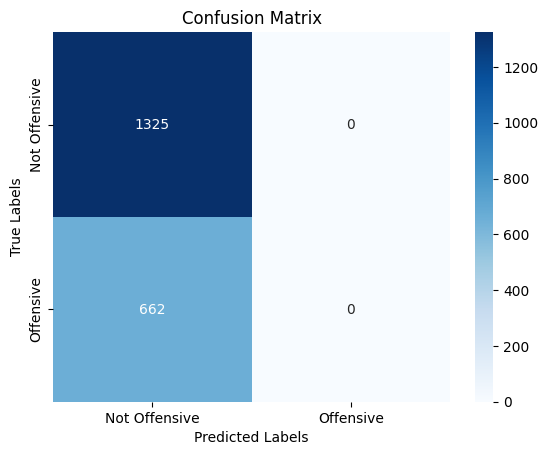

In [ ]:
test_bert(model_bert, test_loader,model_name)